In [56]:
import pandas as pd 
import os 
import numpy as np 
from pathlib import Path
from typing import *
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

# Data Functions

In [57]:
ROOT = os.path.dirname(os.getcwd())+"/data"

def load(path:Path, sep="|"):
    return pd.read_csv(path, sep=sep)

def collect_time_(df:pd.DataFrame,column:str):
    data_times = pd.to_datetime(df[column]).dt
    df["year"] = data_times.year
    df["month"] = data_times.month
    del df_meteo[column]

def set_pickle(object_to_save:object, path:Path):
    with open(path, "wb") as handle:
        pickle.dump(object_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)    

def get_pickle(path:Path):
    with open(path, "rb") as handle:
        o=pickle.load(handle)     
    return o

def convert_altitud(df:pd.DataFrame):
    df["ALTITUD"] = df["ALTITUD"].apply(lambda x: str(x).split("-"))
    df = df.explode("ALTITUD")
    df["ALTITUD"] = df["ALTITUD"].apply(lambda x: int(x) if x!= "nan" else x)
    
    return df

In [58]:
df_meteo_by_day = load(ROOT+"/DATOS_METEO_AGG_DAY.csv", sep=",") 
df_meteo_by_month = load(ROOT+"/DATOS_METEO_AGG_MONTH.csv", sep=",")

In [59]:
df_train = load(ROOT+"/UH_2023_TRAIN.txt")

In [60]:
df_train

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.0000,22215.0
1,14,84318,515,4,660,26,2,0,1,0.0000,22215.0
2,14,85579,340,4,520,32,2,0,1,0.0000,20978.0
3,14,69671,340,4,520,32,2,0,1,0.0000,40722.0
4,14,14001,852,14,NaN,81,1,0,1,0.0000,14126.0
...,...,...,...,...,...,...,...,...,...,...,...
9596,22,37461,239,6,700,52,2,0,1,3.6800,NaN
9597,22,58769,239,6,700,32,2,0,1,4.2500,NaN
9598,22,58769,239,6,700,59,2,0,1,4.0700,NaN
9599,22,88928,239,6,700,40,2,0,1,4.5727,NaN


In [61]:
train_joined_by_day = df_meteo_by_day.merge(df_train, how='inner', on=["CAMPAÑA", "ID_ESTACION"])

In [62]:
train_joined_by_day.shape

(8453, 10625)

In [63]:
display(train_joined_by_day)

,ID_ESTACION,CAMPAÑA,precip1Hour_month_1_day_1,precip1Hour_month_1_day_2,precip1Hour_month_1_day_3,precip1Hour_month_1_day_4,precip1Hour_month_1_day_5,precip1Hour_month_1_day_6,precip1Hour_month_1_day_7,precip1Hour_month_1_day_8,...,windSpeed_month_12_day_31,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,0.0,20.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,11.750000,62285,126,NaN,94,2,0,0,4.0082,16250.0
1,1.0,17.0,0.0,0.045833,0.0,0.0,0.000000,0.000000,0.0,0.0,...,22.533333,81518,388,800,17,1,0,1,0.0000,10070.0
2,1.0,18.0,0.0,0.000000,0.0,0.0,0.000000,0.291667,0.0,0.0,...,5.304167,81518,388,800,17,1,0,1,0.0000,25370.0
3,2.0,15.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,9.604167,19515,973,500,32,2,0,1,0.0000,19544.0
4,2.0,15.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,9.604167,35465,964,500,32,2,0,1,0.0000,13960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8448,19.0,22.0,0.0,0.000000,0.0,0.0,0.108333,0.000000,0.0,0.0,...,6.808333,45680,966,430-470,59,2,0,1,1.7696,NaN
8449,19.0,22.0,0.0,0.000000,0.0,0.0,0.108333,0.000000,0.0,0.0,...,6.808333,67872,966,430-470,15,2,0,1,4.4300,NaN
8450,19.0,22.0,0.0,0.000000,0.0,0.0,0.108333,0.000000,0.0,0.0,...,6.808333,42777,349,445-465,59,1,0,1,0.7800,NaN
8451,19.0,22.0,0.0,0.000000,0.0,0.0,0.108333,0.000000,0.0,0.0,...,6.808333,69003,349,445-465,59,1,0,1,3.5610,NaN


In [64]:
# We set NaN's amplitudes to 0

train_joined_by_day["ALTITUD"] = train_joined_by_day["ALTITUD"].fillna(0)
train_joined_by_day["ALTITUD"] = train_joined_by_day["ALTITUD"].apply(lambda x: str(x).split("-"))
train_joined_by_day = train_joined_by_day.explode("ALTITUD")
train_joined_by_day["ALTITUD"] = train_joined_by_day["ALTITUD"].astype(int)

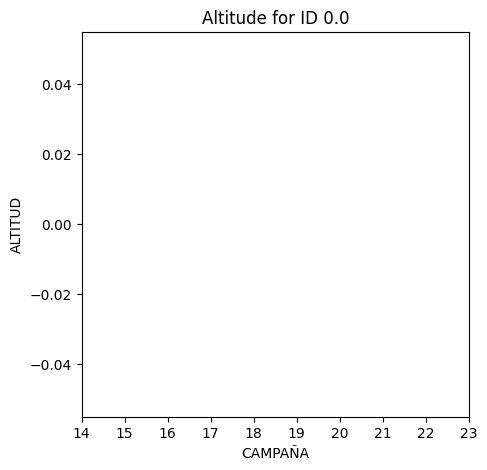

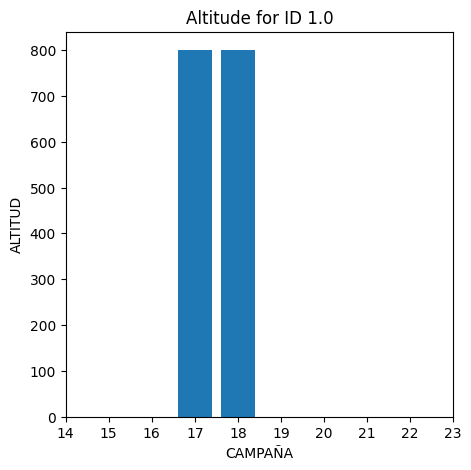

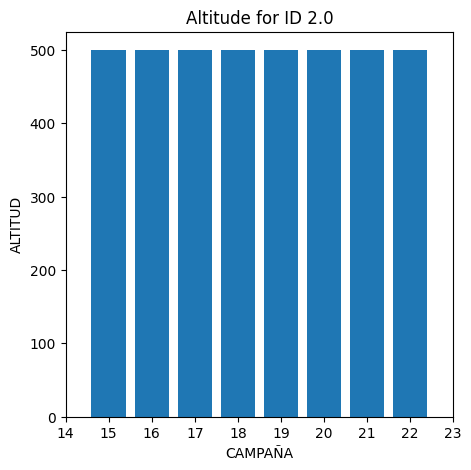

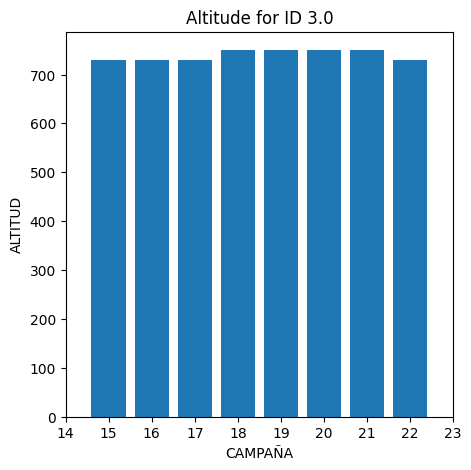

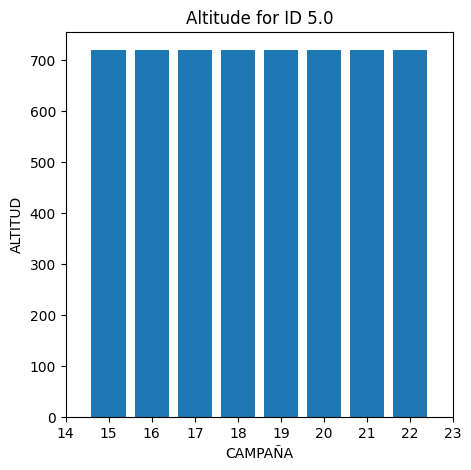

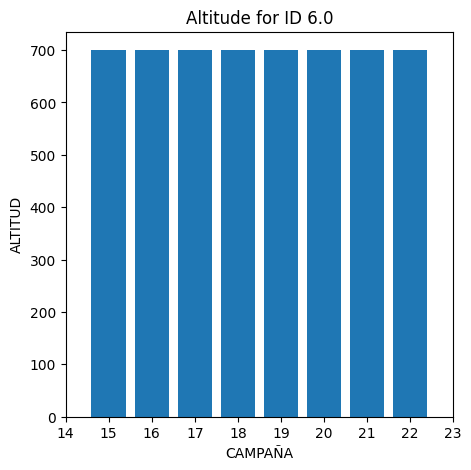

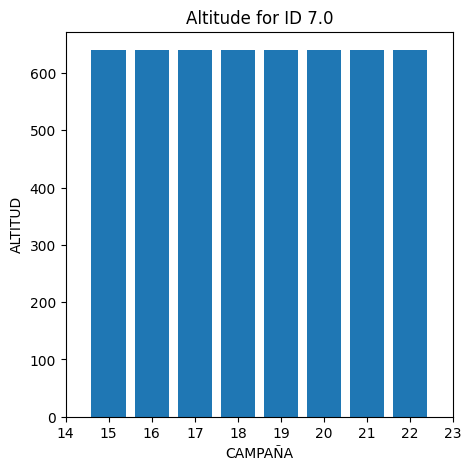

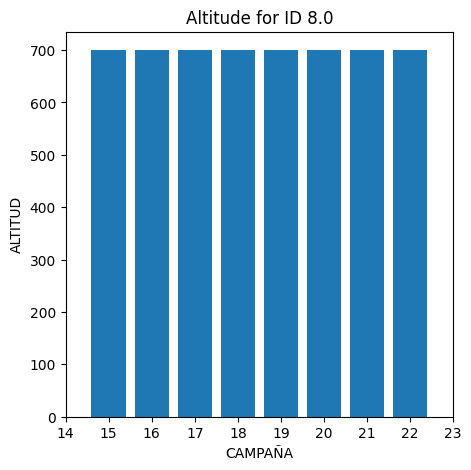

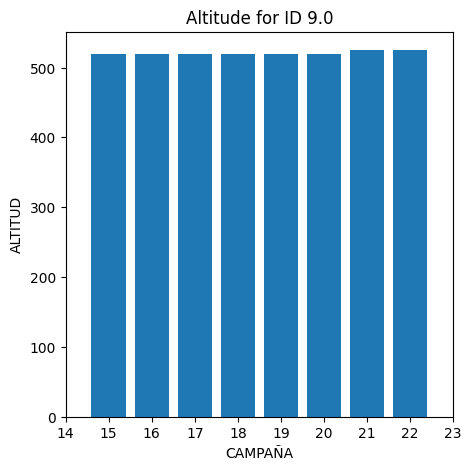

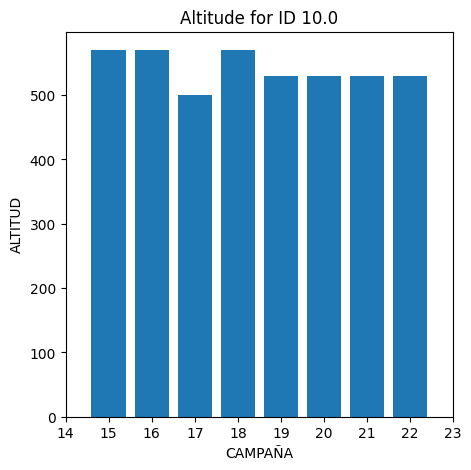

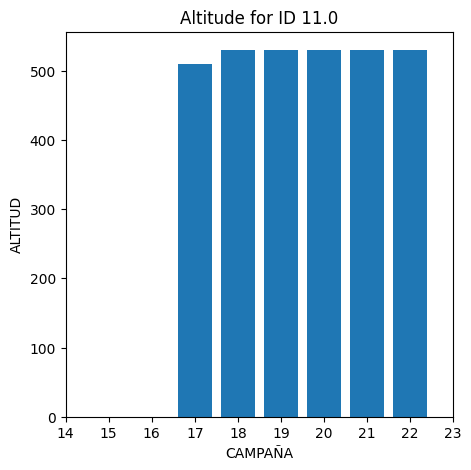

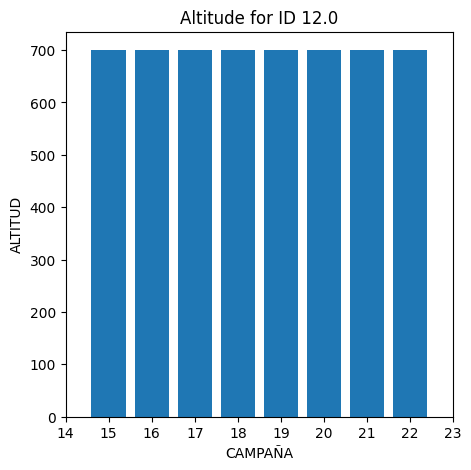

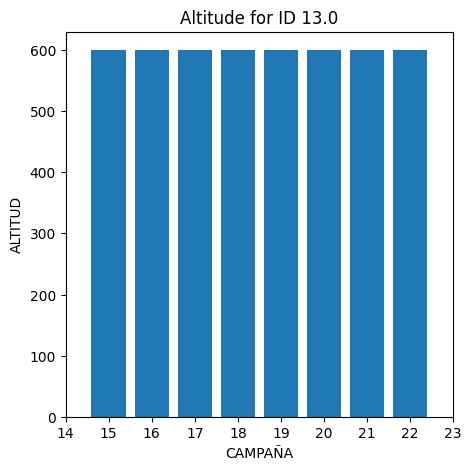

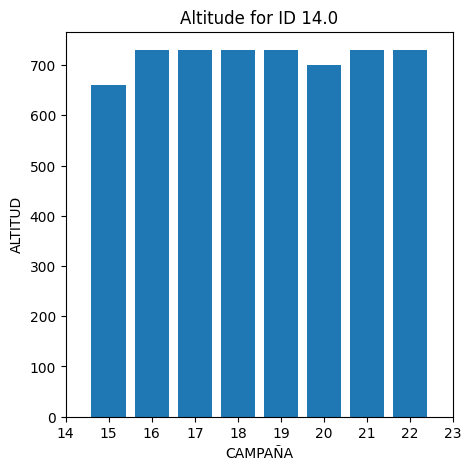

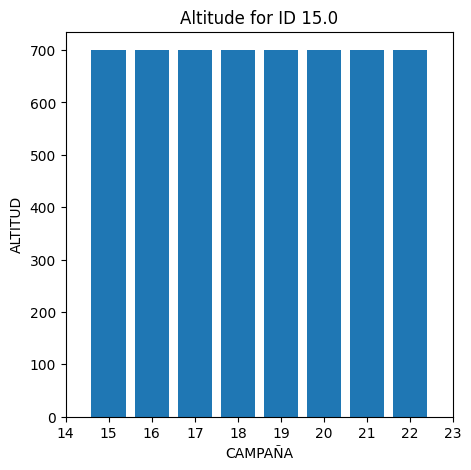

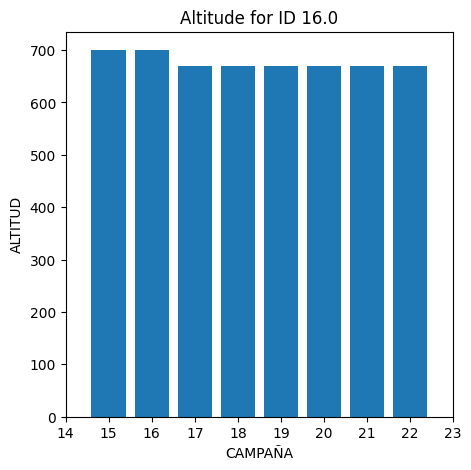

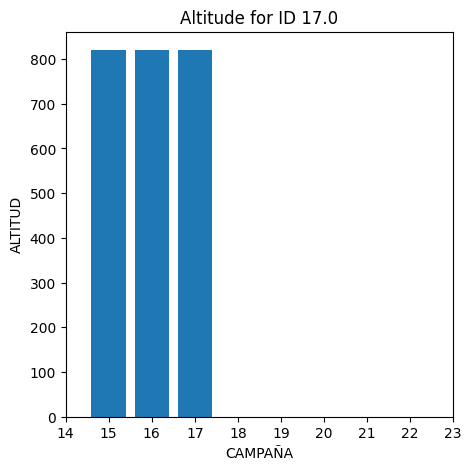

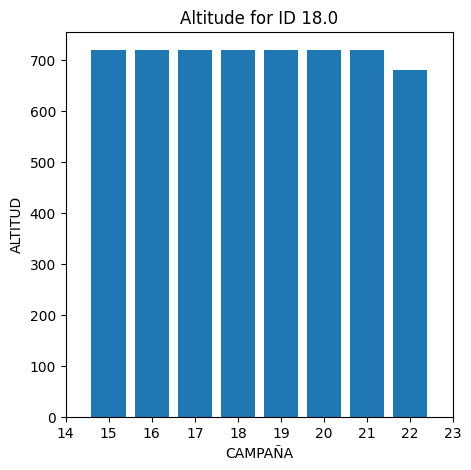

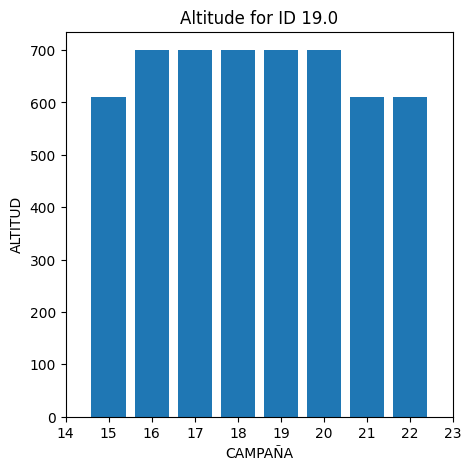

In [65]:
# group dataframe by id
groups = train_joined_by_day.groupby('ID_ESTACION')

# loop through groups and create a separate plot for each group
for name, group in groups:
    fig, ax = plt.subplots(figsize=(5,5))
    ax.bar(group['CAMPAÑA'], group['ALTITUD'])
    ax.set(title=f'Altitude for ID {name}', xlabel='CAMPAÑA', ylabel='ALTITUD')
    ax.set_xlim(14, 23)
    plt.show()

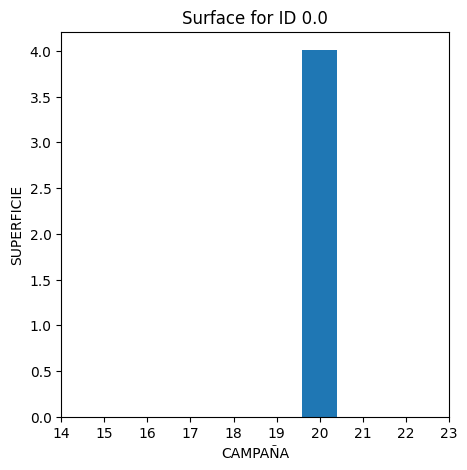

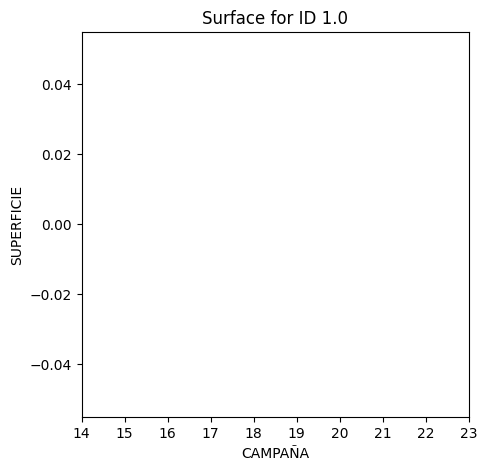

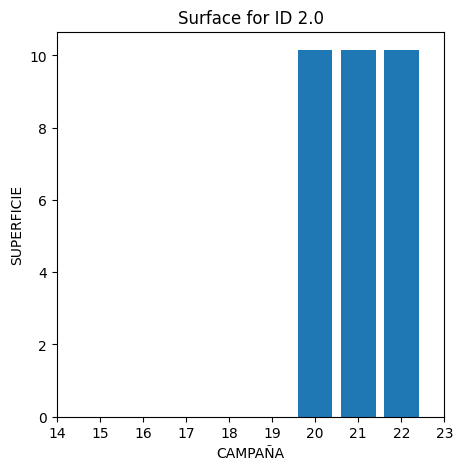

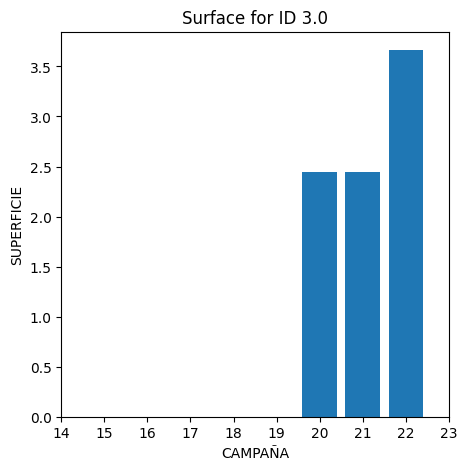

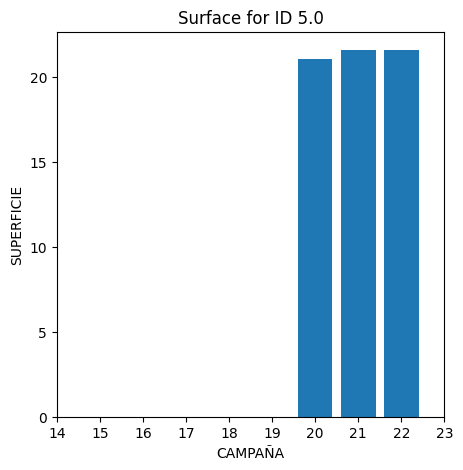

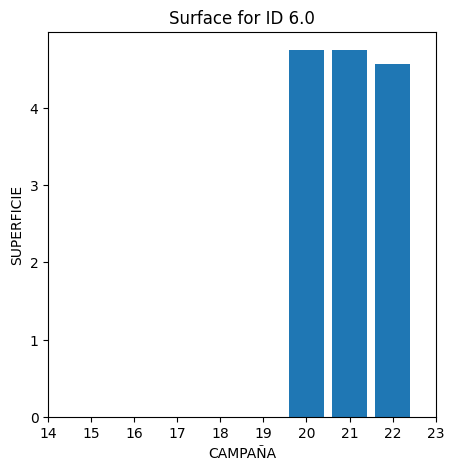

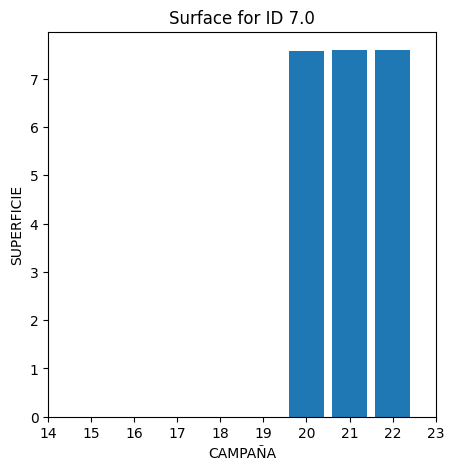

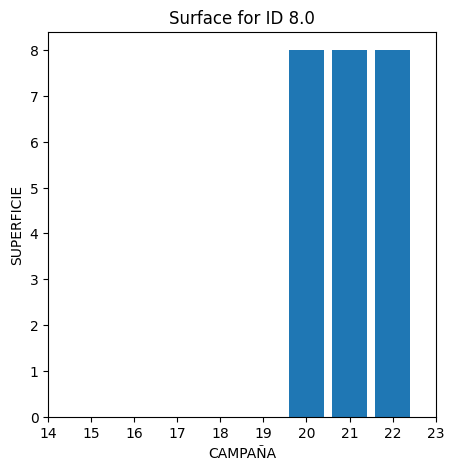

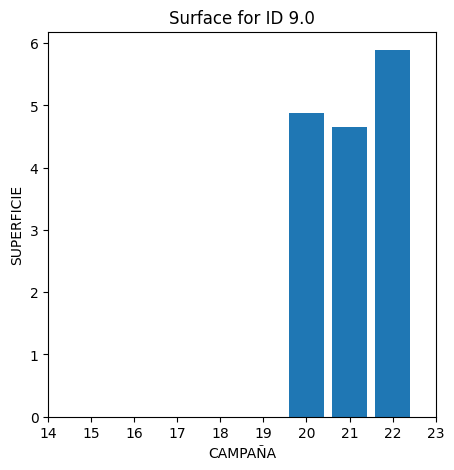

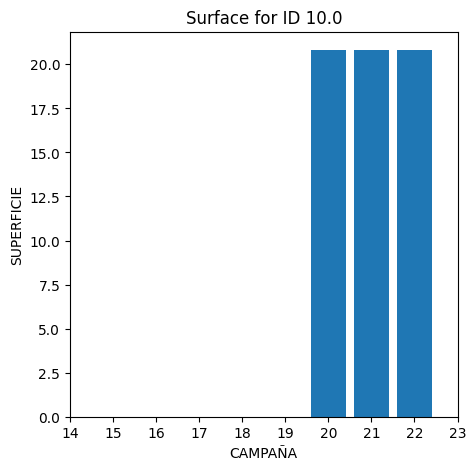

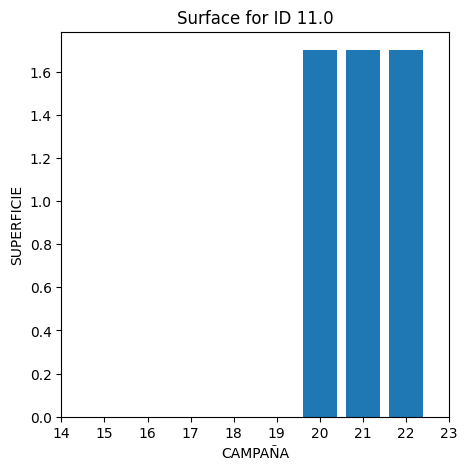

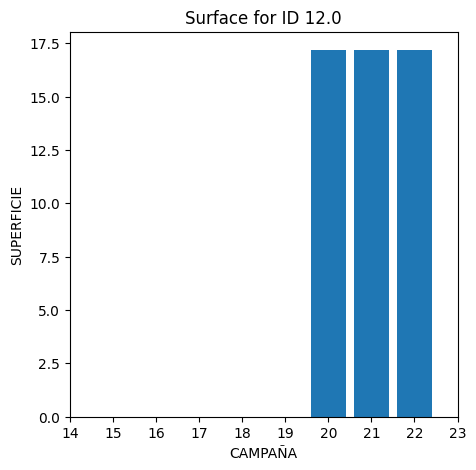

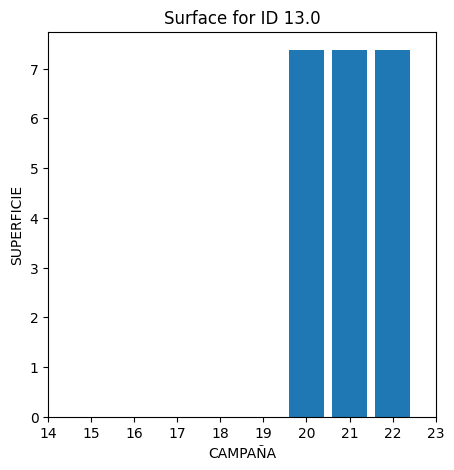

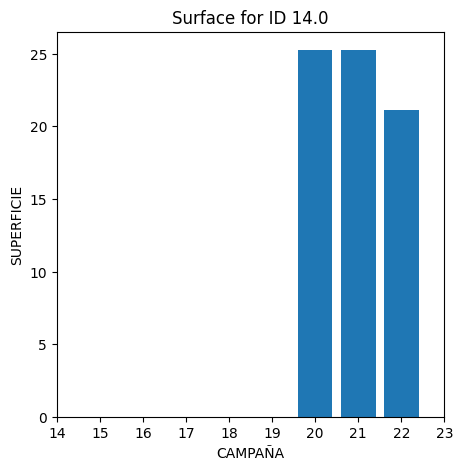

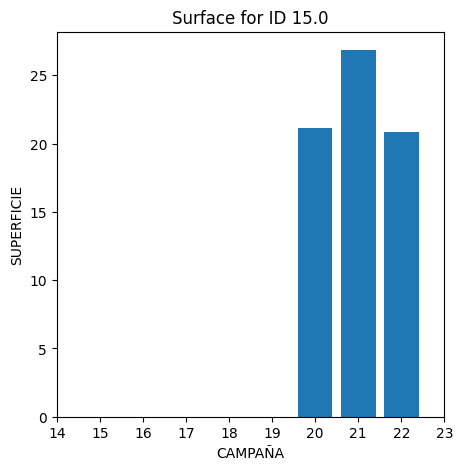

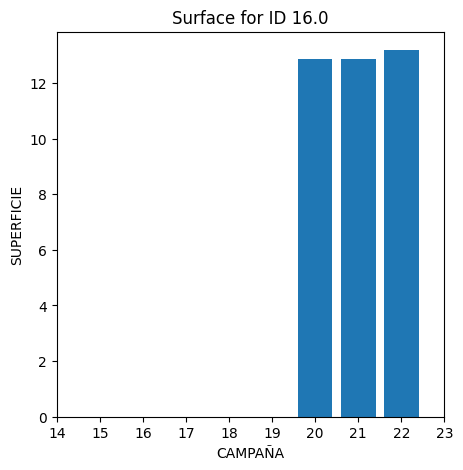

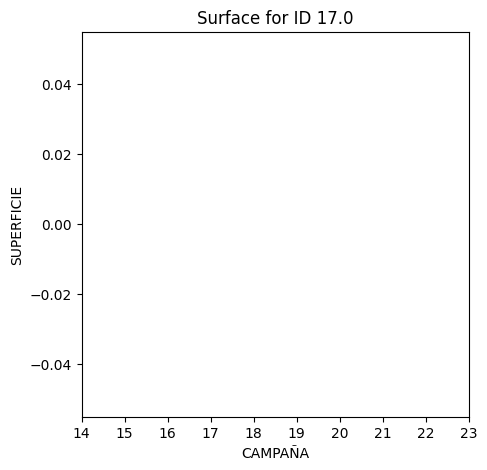

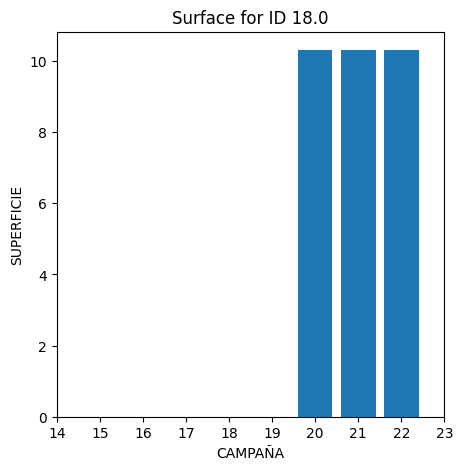

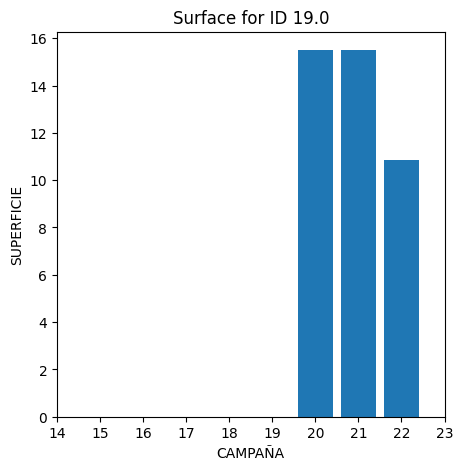

In [66]:
# group dataframe by id
groups = train_joined_by_day.groupby('ID_ESTACION')

# loop through groups and create a separate plot for each group
for name, group in groups:
    fig, ax = plt.subplots(figsize=(5,5))
    ax.bar(group['CAMPAÑA'], group['SUPERFICIE'])
    ax.set(title=f'Surface for ID {name}', xlabel='CAMPAÑA', ylabel='SUPERFICIE')
    ax.set_xlim(14, 23)
    plt.show()

In [67]:
mean_superficie = train_joined_by_day.loc[train_joined_by_day["SUPERFICIE"] != 0, "SUPERFICIE"].mean()
train_joined_by_day["SUPERFICIE"] = train_joined_by_day["SUPERFICIE"].fillna(mean_superficie)

In [68]:
train_joined_by_day_no_altitude = train_joined_by_day.drop(["ALTITUD"], axis=1)

In [69]:
train_joined_by_day_no_altitude.to_csv("../data/DATA_TRAIN_JOINED_DAYS_NO_ALT.csv", header=True, index=False)

## FILL ALTITUD CON RANDOM FOREST

In [37]:
from sklearn.ensemble import RandomForestRegressor

X_train = joined.loc[joined["ALTITUD"] != "nan"]
y_train = X_train["ALTITUD"]
del X_train["ALTITUD"]
del X_train["PRODUCCION"]

X_test = joined.loc[joined["ALTITUD"] == "nan"]
del X_test["ALTITUD"]
del X_test["PRODUCCION"]

In [38]:
print(X_train.isna().sum())

ID_ESTACION                0
CAMPAÑA                    0
month                      0
day                        0
precip1Hour                0
precip6Hour                0
precip24Hour               0
precip2Day                 0
precip3Day                 0
precip7Day                 0
precipMtd                  0
precipYtd                  0
pressureChange             0
pressureMeanSeaLevel       0
relativeHumidity           0
snow1Hour                  0
snow6Hour                  0
snow24Hour                 0
snow2Day                   0
snow3Day                   0
snow7Day                   0
snowMtd                    0
snowYtd                    0
temperature                0
temperatureChange24Hour    0
temperatureMax24Hour       0
temperatureMin24Hour       0
temperatureDewPoint        0
temperatureFeelsLike       0
uvIndex                    0
visibility                 0
windDirection              0
windSpeed                  0
year                       0
ID_FINCA      

In [39]:
regr = RandomForestRegressor(max_depth=5,n_jobs=-1, verbose=1, random_state=0)
regr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.2min finished


RandomForestRegressor(max_depth=5, n_jobs=-1, random_state=0, verbose=1)

In [42]:
predictions = (regr.predict(X_test))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [48]:
joined.loc[joined["ALTITUD"] == "nan", "ALTITUD"] = predictions

<AxesSubplot: >

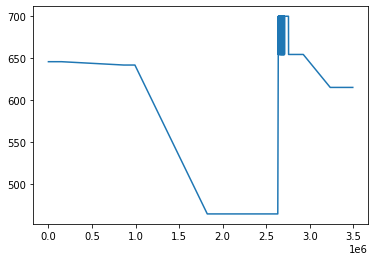

In [46]:
X_test["ALTITUD"].plot()

In [50]:
display(joined)

,ID_ESTACION,CAMPAÑA,month,day,precip1Hour,precip6Hour,precip24Hour,precip2Day,precip3Day,precip7Day,...,year,ID_FINCA,ID_ZONA,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,0,20,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,2020,62285,126,645.950718,94,2,0,0,4.0082,16250.0
1,0,20,1,2,0.0,0.0,0.0,0.0,0.0,0.0,...,2020,62285,126,645.950718,94,2,0,0,4.0082,16250.0
2,0,20,1,3,0.0,0.0,0.0,0.0,0.0,0.0,...,2020,62285,126,645.950718,94,2,0,0,4.0082,16250.0
3,0,20,1,4,0.0,0.0,0.0,0.0,0.0,0.0,...,2020,62285,126,645.950718,94,2,0,0,4.0082,16250.0
4,0,20,1,5,0.0,0.0,0.0,0.0,0.0,0.0,...,2020,62285,126,645.950718,94,2,0,0,4.0082,16250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4998978,19,22,6,30,0.0,0.0,0.0,0.0,0.0,0.0,...,2022,42777,349,445,59,1,0,1,0.7800,NaN
4998979,19,22,6,30,0.0,0.0,0.0,0.0,0.0,0.0,...,2022,42777,349,465,59,1,0,1,0.7800,NaN
4998980,19,22,6,30,0.0,0.0,0.0,0.0,0.0,0.0,...,2022,69003,349,445,59,1,0,1,3.5610,NaN
4998981,19,22,6,30,0.0,0.0,0.0,0.0,0.0,0.0,...,2022,69003,349,465,59,1,0,1,3.5610,NaN


<AxesSubplot: >

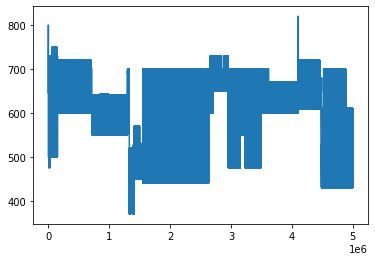

In [52]:
joined.loc[joined["ALTITUD"] != "nan", "ALTITUD"].plot()

In [53]:
joined.to_csv("../data/DATA_TRAIN_JOINED_DAYS.csv", index=False)

# ETO

In [133]:
df_eto = load(ROOT+"/DATOS_ETO.TXT")
df_eto[df_eto.isna().any(axis=1)]


,date,DewpointLocalAfternoonAvg,DewpointLocalAfternoonMax,DewpointLocalAfternoonMin,DewpointLocalDayAvg,DewpointLocalDayMax,DewpointLocalDayMin,DewpointLocalDaytimeAvg,DewpointLocalDaytimeMax,DewpointLocalDaytimeMin,...,WindSpeedLocalMorningAvg,WindSpeedLocalMorningMax,WindSpeedLocalMorningMin,WindSpeedLocalNighttimeAvg,WindSpeedLocalNighttimeMax,WindSpeedLocalNighttimeMin,WindSpeedLocalOvernightAvg,WindSpeedLocalOvernightMax,WindSpeedLocalOvernightMin,ID_ESTACION
0,20150629,285.9,285.9,285.9,286.0,287.0,285.4,285.9,285.9,285.9,...,NaN,NaN,NaN,2.6,5.0,1.1,1.7,2.1,1.1,13
1,20150630,283.0,283.6,282.5,284.3,286.5,282.5,283.2,283.9,282.5,...,2.2,3.8,1.4,2.7,5.2,1.4,1.5,1.9,1.4,13
2,20150701,286.1,286.5,285.5,285.8,288.0,283.8,285.4,286.5,283.8,...,2.7,4.3,1.2,3.0,5.7,1.4,1.9,2.8,1.4,13
3,20150702,288.9,289.4,287.9,288.3,291.8,286.1,287.7,289.4,286.1,...,1.7,2.3,1.2,3.6,5.4,2.4,2.7,3.4,2.4,13
4,20150703,289.1,290.4,288.5,290.5,293.0,287.8,290.6,293.0,288.5,...,3.5,5.0,2.3,3.1,6.0,1.5,1.9,2.2,1.5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51175,20220626,284.0,285.0,283.0,285.0,288.0,283.0,285.0,286.0,283.0,...,2.1,2.6,1.2,2.1,5.2,0.6,1.1,1.6,0.6,8
51176,20220627,289.0,289.0,288.0,288.0,290.0,286.0,289.0,290.0,288.0,...,3.2,3.9,2.2,3.1,5.0,1.4,1.8,2.8,1.4,8
51177,20220628,283.0,285.0,282.0,286.0,290.0,282.0,284.0,287.0,282.0,...,1.8,2.5,1.2,2.4,5.0,1.0,1.3,1.7,1.0,8
51178,20220629,283.0,285.0,282.0,285.0,288.0,282.0,284.0,286.0,282.0,...,2.2,3.1,1.3,2.7,5.4,1.3,1.6,1.9,1.3,8


In [143]:
for i in df_eto.columns:
    print(i)

date
DewpointLocalAfternoonAvg
DewpointLocalAfternoonMax
DewpointLocalAfternoonMin
DewpointLocalDayAvg
DewpointLocalDayMax
DewpointLocalDayMin
DewpointLocalDaytimeAvg
DewpointLocalDaytimeMax
DewpointLocalDaytimeMin
DewpointLocalEveningAvg
DewpointLocalEveningMax
DewpointLocalEveningMin
DewpointLocalMorningAvg
DewpointLocalMorningMax
DewpointLocalMorningMin
DewpointLocalNighttimeAvg
DewpointLocalNighttimeMax
DewpointLocalNighttimeMin
DewpointLocalOvernightAvg
DewpointLocalOvernightMax
DewpointLocalOvernightMin
EvapotranspirationLocalAfternoonAvg
EvapotranspirationLocalAfternoonMax
EvapotranspirationLocalAfternoonMin
EvapotranspirationLocalDayAvg
EvapotranspirationLocalDayMax
EvapotranspirationLocalDayMin
EvapotranspirationLocalDaytimeAvg
EvapotranspirationLocalDaytimeMax
EvapotranspirationLocalDaytimeMin
EvapotranspirationLocalEveningAvg
EvapotranspirationLocalEveningMax
EvapotranspirationLocalEveningMin
EvapotranspirationLocalMorningAvg
EvapotranspirationLocalMorningMax
Evapotranspirat

,date,PrecipAmountLocalDayAvg
0,20150629,0.0
1,20150630,0.0
2,20150701,0.0
3,20150702,0.0
4,20150703,0.0
...,...,...
51175,20220626,0.0
51176,20220627,0.0
51177,20220628,0.0
51178,20220629,0.0


# Explore Functions

In [22]:
   # In this case the test will be the year 2022
# TODO MIRAR MILLOR EL JOIN
def join_train_test_split(df1:pd.DataFrame, df2:pd.DataFrame):

    df1 = df2.join(df1, on="ID_ESTACION",lsuffix="_" ,how="outer")

    train = df1[df1["year"] != 2022]
    test = df1[df1["year"] == 2022]

    train_y = train["PRODUCCION"]
    test_y = test["PRODUCCION"]

    train.drop("PRODUCCION", axis="columns")
    test.drop("PRODUCCION", axis="columns")

    return train, test, train_y, test_y 

    
def compute_correlations(df:pd.DataFrame):
    return (df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates())

def topk_correlations(df:pd.DataFrame, k:float=0.7):
    correlations = compute_correlations(df)
    
    top_k_percent = [pairs for pairs, value in correlations.items() if value >= k]
    return top_k_percent

def select_features_LR(X_train, y_train,X_test, y_test, correlation_pairs):
    pairs_scores = []
    features1,features2 = correlation_pairs
    
    #train
    y_train_indexes = y_train.index[y_train.isna() == False]
    y_train = y_train.dropna()
    
    #test
    y_test_indexes = y_test.index[y_test.isna() == False]
    y_test = y_test.dropna()
    
    
    for p1, p2 in zip(features1,features2):
        #fit the regressors
        Xtr = X_train.iloc[y_train_indexes]
        Xt = X_test.iloc[y_test_indexes]
        
        reg1 = LinearRegression().fit(Xtr[p1].to_numpy().reshape(-1,1), y_train)
        reg2 = LinearRegression().fit(Xtr[p2].to_numpy().reshape(-1,1), y_train)
        
        #scores
        s1 = reg1.score(Xt[p1].to_numpy().reshape(-1,1), y_test)
        s2 = reg2.score(Xt[p2].to_numpy().reshape(-1,1), y_test)
        
        if s1 >= s2:pairs_scores.append((p1,s1, f"lose {p2}"))
            
        else:pairs_scores.append((p2,s2, f"lose {p1}"))
            
        
    return pairs_scores



In [13]:
X_train, X_test, y_train, y_test = join_train_test_split(df_meteo,df_train)


In [14]:
X_train["VARIEDAD"].unique()

array([26., 32., 59., 40., 87., 17., 52., 81., 68.,  9.,  8., 94., 71.,
       15., 23., 43., 48., 62., 65.,  4., 84., 55., 92., 38., nan])

In [134]:
X_test.shape, y_test.shape

((9814, 45), (9814,))

In [135]:
correlations = list(zip(*topk_correlations(X_train)))

In [136]:
newX_train = X_train[X_train["year"] != 2021].reset_index(drop=True)
newy_train = y_train[X_train["year"] != 2021].reset_index(drop=True)

newX_test = X_train[X_train["year"] == 2021].reset_index(drop=True)
newy_test = y_train[X_train["year"] == 2021].reset_index(drop=True)



In [137]:
selected = select_features_LR(X_train=newX_train, y_train=newy_train, X_test=newX_test, y_test=newy_test, correlation_pairs=correlations)
(selected)

[('precip1Hour', -2.8779504330556094e-05, 'lose precip1Hour'),
 ('snow3Day', -2.0864610211557277e-05, 'lose snow2Day'),
 ('temperatureFeelsLike', 0.0010773450963691422, 'lose temperature'),
 ('ID_ZONA', 0.0041460349189286205, 'lose ID_ESTACION'),
 ('ID_ESTACION', -6.263131300543456e-05, 'lose ID_ESTACION_train'),
 ('snow2Day', -2.2035554688493164e-05, 'lose snow24Hour'),
 ('snow3Day', -2.0864610211557277e-05, 'lose snow24Hour'),
 ('precip3Day', -1.0347280501310507e-05, 'lose precip2Day'),
 ('snow3Day', -2.0864610211557277e-05, 'lose snow7Day'),
 ('snow7Day', -2.1595243673511177e-05, 'lose snow2Day'),
 ('windSpeed', 9.527136916642753e-05, 'lose windGust'),
 ('ID_ZONA', 0.0041460349189286205, 'lose ID_ESTACION_train'),
 ('precipYtd', 8.137255169604618e-05, 'lose month'),
 ('precip24Hour', -1.0936298537655986e-05, 'lose precip2Day'),
 ('temperature', 0.0009253992479907325, 'lose temperatureMax24Hour'),
 ('temperatureFeelsLike', 0.0010773450963691422, 'lose temperatureMax24Hour'),
 ('snow7

# Plot Functions


In [185]:
def plot_distribution(df:pd.DataFrame, column:str):
    if df.get("year", None) is not None:
        sns.displot(df, x=column, hue="year", multiple="dodge")
    else:
        sns.displot(df, x=column)
        

def plot_forecasting(x_axis, y_axis, classes: Optional[list], column:str):
    sns.relplot(x=x_axis,y=y_axis,kind="line", hue=classes, markers=True,legend=True)

In [234]:
X_train.columns

Index(['CAMPAÑA', 'ID_FINCA', 'ID_ZONA', 'ID_ESTACION_train', 'ALTITUD',
       'VARIEDAD', 'MODO', 'TIPO', 'COLOR', 'SUPERFICIE', 'PRODUCCION',
       'precip1Hour', 'precip6Hour', 'precip24Hour', 'precip2Day',
       'precip3Day', 'precip7Day', 'precipMtd', 'precipYtd', 'pressureChange',
       'pressureMeanSeaLevel', 'relativeHumidity', 'snow1Hour', 'snow6Hour',
       'snow24Hour', 'snow2Day', 'snow3Day', 'snow7Day', 'snowMtd',
       'snowSeason', 'snowYtd', 'temperature', 'temperatureChange24Hour',
       'temperatureMax24Hour', 'temperatureMin24Hour', 'temperatureDewPoint',
       'temperatureFeelsLike', 'uvIndex', 'visibility', 'windDirection',
       'windGust', 'windSpeed', 'ID_ESTACION', 'year', 'month'],
      dtype='object')

In [16]:
X_train.groupby(["VARIEDAD", "ID_ESTACION_"]).mean()

CAMPAÑA      ID_FINCA     ID_ZONA  MODO  TIPO  COLOR  \
VARIEDAD ID_ESTACION_                                                           
4.0      5.0           18.280000  50081.640000  340.040000   2.0   1.0    1.0   
         16.0          18.000000  44057.000000  272.000000   2.0   1.0    1.0   
8.0      3.0           19.500000  59388.000000   71.000000   1.5   0.0    0.0   
         7.0           19.000000  64798.000000  616.000000   2.0   0.0    0.0   
         15.0          17.500000  52008.000000  412.000000   2.0   0.0    0.0   
...                          ...           ...         ...   ...   ...    ...   
94.0     9.0           20.500000  13333.000000  784.000000   2.0   0.0    0.0   
         15.0          19.562500  49373.625000  464.250000   2.0   0.0    0.0   
         16.0          20.000000  53738.750000  772.500000   2.0   0.0    0.0   
         18.0          20.750000  66942.125000  277.625000   2.0   0.0    0.0   
         19.0          20.666667  61622.333333  557.333333   2.0   0.0    0.0   

                       SUPERFICIE    PRODUCCION  precip1Hour  precip6Hour  \
VARIEDAD ID_ESTACION_                                                       
4.0      5.0             2.907208  19812.412640          NaN          NaN   
         16.0            1.158571  14672.834571          NaN          NaN   
8.0      3.0             1.181950  12205.000000          NaN          NaN   
         7.0             0.629400   3789.000000          NaN          NaN   
         15.0            1.776950  37654.566000          NaN          NaN   
...                           ...           ...          ...          ...   
94.0     9.0             1.459700   8970.000000          NaN          NaN   
         15.0            1.541813  11294.548000          NaN          NaN   
         16.0            2.245800  10133.750000          NaN          NaN   
         18.0            3.057438   9850.904000          NaN          NaN   
         19.0            1.340567   5146.666667          NaN          NaN   

                       ...  temperatureDewPoint  temperatureFeelsLike  \
VARIEDAD ID_ESTACION_  ...                                              
4.0      5.0           ...                  NaN                   NaN   
         16.0          ...                  NaN                   NaN   
8.0      3.0           ...                  NaN                   NaN   
         7.0           ...                  NaN                   NaN   
         15.0          ...                  NaN                   NaN   
...                    ...                  ...                   ...   
94.0     9.0           ...                  NaN                   NaN   
         15.0          ...                  NaN                   NaN   
         16.0          ...                  NaN                   NaN   
         18.0          ...                  NaN                   NaN   
         19.0          ...                  NaN                   NaN   

                       uvIndex  visibility  windDirection  windGust  \
VARIEDAD ID_ESTACION_                                                 
4.0      5.0               NaN         NaN            NaN       NaN   
         16.0              NaN         NaN            NaN       NaN   
8.0      3.0               NaN         NaN            NaN       NaN   
         7.0               NaN         NaN            NaN       NaN   
         15.0              NaN         NaN            NaN       NaN   
...                        ...         ...            ...       ...   
94.0     9.0               NaN         NaN            NaN       NaN   
         15.0              NaN         NaN            NaN       NaN   
         16.0              NaN         NaN            NaN       NaN   
         18.0              NaN         NaN            NaN       NaN   
         19.0              NaN         NaN            NaN       NaN   

                       windSpeed  ID_ESTACION  year  month  
VARIEDAD ID_ESTACION_             

In [232]:
(df_train["VARIEDAD"].unique())

array([26, 32, 59, 40, 87, 17, 52, 81, 68,  9, 71, 15, 84, 62,  8, 43, 65,
       92, 55,  4, 94, 23, 38, 48])

In [21]:
X_train

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION_,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,...,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION,year,month
0.0,14.0,76953.0,515.0,4.0,660,26.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
1.0,14.0,84318.0,515.0,4.0,660,26.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
2.0,14.0,85579.0,340.0,4.0,520,32.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
3.0,14.0,69671.0,340.0,4.0,520,32.0,2.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
12.0,14.0,5696.0,919.0,14.0,650-660,59.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,9.5,0.0,13.82,300.0,34.6,21.6,1219242,2021.0,12.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.1,9.0,0.0,13.98,290.0,30.2,19.4,1219243,2021.0,12.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.8,8.8,0.0,14.15,300.0,29.9,19.4,1219244,2021.0,12.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,8.0,0.0,13.55,290.0,28.4,19.1,1219247,2021.0,12.0


In [18]:
(X_train.groupby(["ID_FINCA", "VARIEDAD", "year"])).mean()

,,,CAMPAÑA,ID_ZONA,ID_ESTACION_,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION,precip1Hour,precip6Hour,...,temperatureMin24Hour,temperatureDewPoint,temperatureFeelsLike,uvIndex,visibility,windDirection,windGust,windSpeed,ID_ESTACION,month
ID_FINCA,VARIEDAD,year,,,,,,,,,,,,,,,,,,,,,
